# Simulation results analysis

This notebook serves to analyze the results of the simulations for SEL.

In [1]:
import pycof as pc
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

We first specify where to fetch the results from.
This can be from a remote server or locally.

In [2]:
# Folder where results are stored (locally as well as on the remote server if any)
folder_path = os.path.join(os.environ['HOME'], 'StatisticallyEnhancedLearning', '.data') + '/'
# Host name on the config file at ~/.ssh/config
server = None
# Simulation version. V4 is when the form of the SEL feature is not know, V3 assumes it is known.
simu_version  = 'v4_'  # '', 'v2_', 'v3_', 'v4_'

In [3]:
if server:
    # First we sync the folder 
    os.system(f"rsync -r -e ssh --include='*/' --include='simulation_{simu_version}results*.parquet' --exclude='*' {server}:{folder_path} {folder_path}")

latest_file = max([f for f in os.listdir(folder_path) if f.startswith(f'simulation_{simu_version}results')])
results = pc.read(os.path.join(folder_path, latest_file))

Let's check how many simulations are done.

In [5]:
_done = results[~results.rmse_ols_vanilla.isnull()].shape[0]
_ttl = results.shape[0]
print(f'Done {_done:,} out of {_ttl:,} ({_done / _ttl:.2%})')

Done 9,000 out of 9,000 (100.00%)


We set the ML model we want to evaluate the performance from. By default, we use XGBoost.

In [ ]:
# x-axis column
gp = 'n_cols'
# ML model trained
model = 'xgb'

In [7]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

We transform the data to scale it to the base regular model (Vanilla).
RMSE for Vanilla model will be of base 100 and we compare versus SEL of level 2 and 3.

In [8]:
results.eval(f'rmse_{model}_vanilla_base100 = rmse_{model}_vanilla / rmse_{model}_vanilla', inplace=True)
results.eval(f'rmse_{model}_moments_base100 = rmse_{model}_moments / rmse_{model}_vanilla', inplace=True)
results.eval(f'rmse_{model}_sel_base100 = rmse_{model}_sel / rmse_{model}_vanilla', inplace=True)

We prepare the data for the plot by computing the average RMSE per group variable (e.g. nb of columns) as well as percentiles for 95% credible interval.

In [9]:
_df = results.dropna(subset=f'rmse_{model}_vanilla')

gp_vanilla = _df.groupby(gp)[[f'rmse_{model}_vanilla_base100']].agg(['mean', 'std', 'min', 'max', 'count', percentile(5), percentile(95)])[f'rmse_{model}_vanilla_base100']
gp_moments = _df.groupby(gp)[[f'rmse_{model}_moments_base100']].agg(['mean', 'std', 'min', 'max', 'count', percentile(5), percentile(95)])[f'rmse_{model}_moments_base100']
gp_sel = _df.groupby(gp)[[f'rmse_{model}_sel_base100']].agg(['mean', 'std', 'min', 'max', 'count', percentile(5), percentile(95)])[f'rmse_{model}_sel_base100']

In [10]:
gp_moments['mean'] *= 100
gp_moments['percentile_5'] *= 100
gp_moments['percentile_95'] *= 100
gp_sel['mean'] *= 100
gp_sel['percentile_5'] *= 100
gp_sel['percentile_95'] *= 100
gp_vanilla['mean'] *= 100
gp_vanilla['percentile_5'] *= 100
gp_vanilla['percentile_95'] *= 100

Let's plot it now.

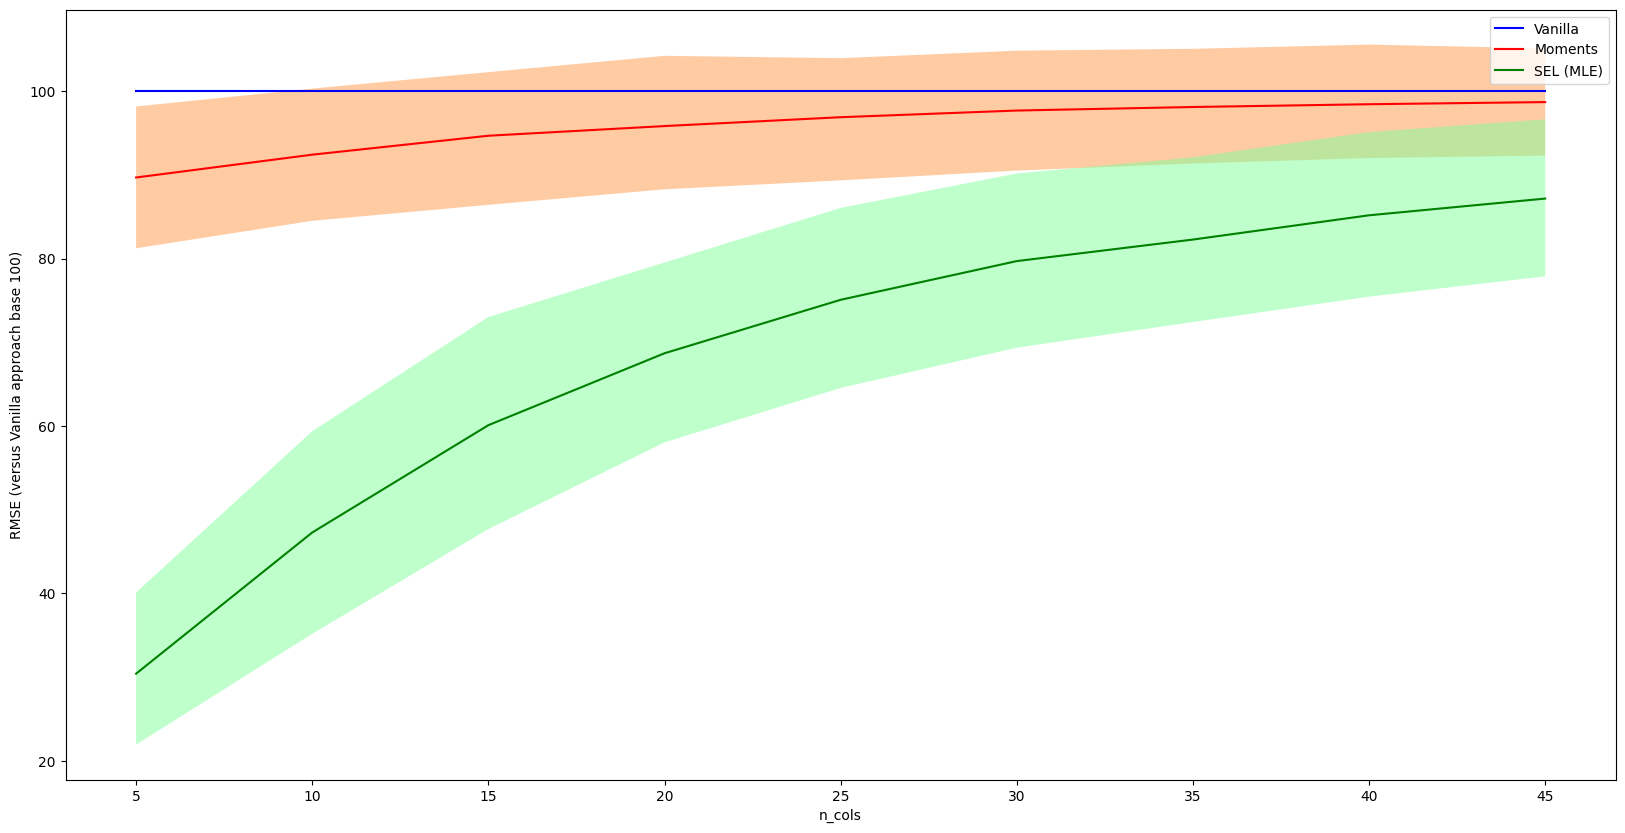

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(gp_vanilla.index, gp_vanilla['mean'], color='blue', label='Vanilla')
plt.fill_between(gp_vanilla.index, gp_vanilla['percentile_5'], gp_vanilla['percentile_95'], alpha=0.5, facecolor='#089FFF')

plt.plot(gp_moments.index, gp_moments['mean'], color='red', label='moments'.capitalize())
plt.fill_between(gp_moments.index, gp_moments['percentile_5'], gp_moments['percentile_95'], alpha=0.5, facecolor='#FF9848')

plt.plot(gp_sel.index, gp_sel['mean'], color='green', label='sel (mle)'.upper())
plt.fill_between(gp_sel.index, gp_sel['percentile_5'], gp_sel['percentile_95'], alpha=0.5, facecolor='#7EFF99')

plt.ylabel('RMSE (versus Vanilla approach base 100)')
plt.xlabel(gp)
plt.legend()
plt.show()

Let us simply extract a small table to be able to replicate the plot on the final paper.

In [13]:
_a = gp_sel[['mean', 'percentile_5', 'percentile_95']].rename(columns={'mean': 'sel_mean', 'percentile_5': 'sel_p5', 'percentile_95': 'sel_p95'})
_b = gp_moments[['mean', 'percentile_5', 'percentile_95']].rename(columns={'mean': 'moments_mean', 'percentile_5': 'moments_p5', 'percentile_95': 'moments_p95'})
_b['vanilla'] = 100

_perf = pd.concat([_a, _b], axis=1)

_perf.reset_index().to_csv('SimuResultsCauchy.csv')

We can observe that the SEL features help drastically improve the performance of the model.
SEL of level 2 (moments) helps reduce the RMSE but level 3 (advanced modeling features) help further reduce it.
We also observe that as the number of features increases the performance converges to the base vanilla model.
This suggests that the information contained in the added features get diluted among the others when multiple features are included (marginal information decreases).